In [1]:
import numpy as np
import math
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import os

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/testA.csv")

## reference
- https://tianchi.aliyun.com/forum/postDetail?spm=5176.12586969.1002.21.3b30685680jNhK&postId=164618

###  Drop columns with only one value (policyCode)

In [3]:
def drop_column(df, col_name):
    """
    function to drop selected columns in the dataframe
    @param df: dataframe
    @param col_name: columns to be dropped
    return: dataframe after dropping the columns
    """
    df = df.drop(col_name, axis=1)
    return df

In [4]:
train = drop_column(train, ["id", "policyCode"])

test = drop_column(test, ["id", "policyCode"])

### Fill missing values
- categorical
    - employmentLength: as it is a categorical, create another type "NA" to fill missing values
    - title, employmentTitle, postCode: as only three records have missing values, fill with mode
- numeric
    - dti: fill 1000
    - revolUtil, pubRecBankruptcies: median
    - n0-n14: median

In [5]:
def fill_value(df, col_list, fill=0):
    """
    a function to fill missing values
    @param df: dataframe
    @param col_list: list of column names
    @param fill: int (0) or str (mean, mode, median)
    return: preprocessed dataframe
    """
    if type(fill) == int or fill not in ["mean", "median", "mode"]:
        df[col_list] = df[col_list].fillna(fill)
    else:
        if fill == "mean":
            val = df[col_list].mean()
            val_map = val.to_dict()
        elif fill == "median":
            val = df[col_list].median()
            val_map = val.to_dict()
        else:
            val = df[col_list].mode()
            val_map = val.loc[0].to_dict()
        
        print(val_map)
        
        for col in col_list:
            df[col] = df[col].replace(np.nan, val_map[col])
        
    return df

In [6]:
def fill_missing_value(df):
    """
    fill missing values in the dataframe
    @param df: dataframe
    """
    # later will encode it into digits
    df = fill_value(df, ["employmentLength"], fill = "NA")
    
    # use the mode to fill categorical features
    df = fill_value(df, ["title", "employmentTitle", "postCode"], fill="mode") 
    
    # original max is 999 (infinite), now fill missing value with 1000, later will discretize it into bins
    df = fill_value(df, ["dti"], fill=1000) 
    
    # below are skewed features
    df = fill_value(df, ["revolUtil", "pubRecBankruptcies"], fill="median") 
    df = fill_value(df, ["n%d" % i for i in range(15)], fill="median") 
    
    return df

In [7]:
train = fill_missing_value(train) 

{'title': 0.0, 'employmentTitle': 54.0, 'postCode': 134.0}
{'revolUtil': 52.1, 'pubRecBankruptcies': 0.0}
{'n0': 0.0, 'n1': 3.0, 'n2': 5.0, 'n3': 5.0, 'n4': 4.0, 'n5': 7.0, 'n6': 7.0, 'n7': 7.0, 'n8': 13.0, 'n9': 5.0, 'n10': 11.0, 'n11': 0.0, 'n12': 0.0, 'n13': 0.0, 'n14': 2.0}


In [8]:
test = fill_missing_value(test)

{'title': 0.0, 'employmentTitle': 54.0, 'postCode': 134.0}
{'revolUtil': 52.3, 'pubRecBankruptcies': 0.0}
{'n0': 0.0, 'n1': 3.0, 'n2': 5.0, 'n3': 5.0, 'n4': 4.0, 'n5': 7.0, 'n6': 7.0, 'n7': 7.0, 'n8': 13.0, 'n9': 5.0, 'n10': 11.0, 'n11': 0.0, 'n12': 0.0, 'n13': 0.0, 'n14': 2.0}


In [9]:
print(train.isnull().sum())
print(test.isnull().sum())

loanAmnt              0
term                  0
interestRate          0
installment           0
grade                 0
subGrade              0
employmentTitle       0
employmentLength      0
homeOwnership         0
annualIncome          0
verificationStatus    0
issueDate             0
isDefault             0
purpose               0
postCode              0
regionCode            0
dti                   0
delinquency_2years    0
ficoRangeLow          0
ficoRangeHigh         0
openAcc               0
pubRec                0
pubRecBankruptcies    0
revolBal              0
revolUtil             0
totalAcc              0
initialListStatus     0
applicationType       0
earliesCreditLine     0
title                 0
n0                    0
n1                    0
n2                    0
n3                    0
n4                    0
n5                    0
n6                    0
n7                    0
n8                    0
n9                    0
n10                   0
n11             

### Encode categorical features
- grade, subGrade, employmentLength

In [10]:
grade_dict = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}

employmentLength_dict = {'NA':0, '< 1 year':1, '1 year':2, '2 years':3, '3 years': 4, '4 years': 5,
                         '5 years':6, '6 years':7,'7 years':8, '8 years':9, '9 years':10, '10+ years':11}

def get_sub_grade(grade, sub):
    """
    encode subGrade into digits
    @param grade: the digit of the grade
    @param sub: letter of the subgrade
    """
    return grade*10 + int(sub[1])

def encode(df):
    """
    encode the categorical features (grade, subGrade, employmentLength) into digits
    @param df: dataframe
    """
    df['grade'] = df['grade'].apply(lambda x: x if x not in grade_dict else grade_dict[x])
    
    df['subGrade'] = df.apply(lambda row: get_sub_grade(row['grade'],row['subGrade']), axis=1)
    
    df['employmentLength'] = df['employmentLength'].apply(lambda x: employmentLength_dict[x])
    
    return df

In [11]:
train = encode(train)
test = encode(test)

In [12]:
train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,35000.0,5,19.52,917.97,4,42,320.0,3,2,110000.0,2,2014-07-01,1,1,137.0,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,Aug-2001,1.0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,18000.0,5,18.49,461.90,3,32,219843.0,6,0,46000.0,2,2012-08-01,0,0,156.0,18,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,May-2002,1723.0,0.0,3.0,5.0,5.0,10.0,7.0,7.0,7.0,13.0,5.0,13.0,0.0,0.0,0.0,2.0
2,12000.0,5,16.99,298.17,3,33,31698.0,9,0,74000.0,2,2015-10-01,0,0,337.0,14,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,May-2006,0.0,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,11000.0,3,7.26,340.96,0,4,46854.0,11,1,118000.0,1,2015-08-01,0,4,148.0,11,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,May-1999,4.0,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,3000.0,3,12.99,101.07,2,22,54.0,0,1,29000.0,2,2016-03-01,0,10,301.0,21,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,Aug-1977,11.0,1.0,2.0,7.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


## Deal with date features
- transform the earliestCreditLine and issueDate into months
- compute the difference in months between earliestCreditLine and issueDate
- keep issueDate and earliestCreditLine (months) as cate_features

In [13]:
def trans_issueDate(issueDate):
    """
    convert issueDatet to number of months
    @param issueDate: YYYY-MM-DD
    """
    year, month, day = issueDate.split('-')
    return int(year)*12 + int(month) - 1


def trans_earliesCreditLine(earliesCreditLine):
    """
    convert earliesCreditLine to number of months
    @param earliesCreditLine: m-YYYY
    """
    month_dict = {"Jan":1, "Feb":2, "Mar":3, "Apr":4, "May":5, "Jun":6, "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12}
    month, year = earliesCreditLine.split('-')
    month = month_dict[month]
    
    return int(year)*12 + month - 1


def compute_month_diff(df):
    """
    compute the number months from earliesCreditLine to issueDate of the loan
    @param df: dataframe
    """
    
    df['issueDate'] = df['issueDate'].apply(lambda x: trans_issueDate(x))
    df['earliesCreditLine'] = df['earliesCreditLine'].apply(lambda x: trans_earliesCreditLine(x))
    df['month_diff'] = df['issueDate'] - df['earliesCreditLine']
    
    return df


In [14]:
train = compute_month_diff(train)

test = compute_month_diff(test)

In [15]:
train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,month_diff
0,35000.0,5,19.52,917.97,4,42,320.0,3,2,110000.0,2,24174,1,1,137.0,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,24019,1.0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,155
1,18000.0,5,18.49,461.90,3,32,219843.0,6,0,46000.0,2,24151,0,0,156.0,18,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,24028,1723.0,0.0,3.0,5.0,5.0,10.0,7.0,7.0,7.0,13.0,5.0,13.0,0.0,0.0,0.0,2.0,123
2,12000.0,5,16.99,298.17,3,33,31698.0,9,0,74000.0,2,24189,0,0,337.0,14,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,24076,0.0,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,113
3,11000.0,3,7.26,340.96,0,4,46854.0,11,1,118000.0,1,24187,0,4,148.0,11,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,23992,4.0,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0,195
4,3000.0,3,12.99,101.07,2,22,54.0,0,1,29000.0,2,24194,0,10,301.0,21,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,23731,11.0,1.0,2.0,7.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,463


### Construct new features

In [20]:
def feature_interaction(df):
    """
    construct new features by feature interaction
    add 0.1 in denominator to avoid dividing by 0
    @param df: dataframe
    """
    
    # 贷款（本金加利息） / 信贷周转余额
    df['installment_term_revolBal'] = df['installment'] * 12 * df['term'] / (df['revolBal'] + 0.1)
    
    # 循环额度利用率 / 信贷周转余额
    df['revolUtil_revolBal'] = df['revolUtil'] / (df['revolBal'] + 0.1)
    
    # 借款人信用档案中 未结信用额度 / 当前的信用额度总数
    df['openAcc_totalAcc'] = df['openAcc'] / df['totalAcc']
    
    # 有的债务收入比为负值，取绝对值
    df['dti'] = np.abs(df['dti'])
    
    # 贷款金额占借款人所有债务的比例
    df['loanAmnt_dti_annualIncome'] = df['loanAmnt'] / (np.abs(df['dti']) * df['annualIncome'] + 0.1)
    
    # 收入比贷款额度
    df['annualIncome_loanAmnt'] = df['annualIncome'] / (df['loanAmnt'] + 0.1)
    
    # 收入比分期付款金额
    df['annualIncome_installment'] = df['annualIncome'] / (df['installment'] + 0.1)
    
    # 信贷周转余额 / 贷款金额
    df['revolBal_loanAmnt'] = df['revolBal'] / (df['loanAmnt'] + 0.1)
    
    # 信贷周转余额 / 分期付款金额
    df['revolBal_installment'] = df['revolBal'] / (df['installment'] + 0.1)

    
    return df

In [21]:
train = feature_interaction(train)

test = feature_interaction(test)

In [22]:
train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,month_diff,annualIncome_bin,loanAmnt_bin,interestRate_bin,dti_bin,installment_bin,revolBal_bin,revolUtil_bin,installment_term_revolBal,revolUtil_revolBal,openAcc_totalAcc,loanAmnt_dti_annualIncome,annualIncome_loanAmnt,annualIncome_installment,revolBal_loanAmnt,revolBal_installment
0,35000.0,5,19.52,917.97,4,42,320.0,3,2,110000.0,2,24174,1,1,137.0,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,24019,1.0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,155,8,9,27,14,28,24,13,2.278020,0.002022,0.259259,0.018662,3.142848,119.816572,0.690798,26.335682
1,18000.0,5,18.49,461.90,3,32,219843.0,6,0,46000.0,2,24151,0,0,156.0,18,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,24028,1723.0,0.0,3.0,5.0,5.0,10.0,7.0,7.0,7.0,13.0,5.0,13.0,0.0,0.0,0.0,2.0,123,2,6,25,25,18,19,9,1.835838,0.002577,0.722222,0.014061,2.555541,99.567100,0.838662,32.675325
2,12000.0,5,16.99,298.17,3,33,31698.0,9,0,74000.0,2,24189,0,0,337.0,14,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,24076,0.0,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,113,5,4,23,21,10,5,14,3.884023,0.011246,0.407407,0.007122,6.166615,248.097361,0.383830,15.442384
3,11000.0,3,7.26,340.96,0,4,46854.0,11,1,118000.0,1,24187,0,4,148.0,11,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,23992,4.0,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0,195,8,4,2,14,13,13,15,1.233860,0.005287,0.321429,0.005417,10.727175,345.980179,0.904355,29.167888
4,3000.0,3,12.99,101.07,2,22,54.0,0,1,29000.0,2,24194,0,10,301.0,21,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,23731,11.0,1.0,2.0,7.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,463,0,0,15,28,1,2,6,1.236708,0.010877,0.444444,0.003217,9.666344,286.646239,0.980634,29.079767


### Discretize numeric features into bins by quantile
- 10 bins: annualIncome, loanAmnt
- 30 bins: interestRate, installment, revolBal, revolUtil, dti_bin

In [23]:
def discretize_bin(df, col_list, n_bins=10):
    """
    discretize continuous features into discrete bins
    @param df: datamframe
    @param col_list: list of feature names
    @param n_bins: number of bins
    """
    
    labels = list(range(n_bins))
    
    for col in col_list:
        df[col + "_bin"] = pd.qcut(df[col], n_bins, labels=labels, duplicates='drop')
    
    return df

In [24]:
# discretize into 10 bins
discretize_col_list = ["annualIncome", "loanAmnt"]

train = discretize_bin(train, discretize_col_list, n_bins=10)
test = discretize_bin(test, discretize_col_list, n_bins=10)


# discretize into 30 bins
discretize_col_list = ['interestRate', 'dti','installment','revolBal','revolUtil']

train = discretize_bin(train, discretize_col_list, n_bins=30)
test = discretize_bin(test, discretize_col_list, n_bins=30)

In [25]:
train["revolUtil_bin"].value_counts()

8     27400
24    27248
26    27233
11    27180
6     27128
15    27032
0     26947
28    26889
1     26879
3     26855
16    26852
20    26794
19    26777
13    26723
23    26641
5     26601
2     26598
14    26584
4     26512
22    26512
18    26430
21    26402
25    26397
12    26341
10    26321
9     26315
17    26263
29    26249
27    25977
7     25920
Name: revolUtil_bin, dtype: int64

In [26]:
train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,month_diff,annualIncome_bin,loanAmnt_bin,interestRate_bin,dti_bin,installment_bin,revolBal_bin,revolUtil_bin,installment_term_revolBal,revolUtil_revolBal,openAcc_totalAcc,loanAmnt_dti_annualIncome,annualIncome_loanAmnt,annualIncome_installment,revolBal_loanAmnt,revolBal_installment
0,35000.0,5,19.52,917.97,4,42,320.0,3,2,110000.0,2,24174,1,1,137.0,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,24019,1.0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,155,8,9,27,14,28,24,13,2.278020,0.002022,0.259259,0.018662,3.142848,119.816572,0.690798,26.335682
1,18000.0,5,18.49,461.90,3,32,219843.0,6,0,46000.0,2,24151,0,0,156.0,18,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,24028,1723.0,0.0,3.0,5.0,5.0,10.0,7.0,7.0,7.0,13.0,5.0,13.0,0.0,0.0,0.0,2.0,123,2,6,25,25,18,19,9,1.835838,0.002577,0.722222,0.014061,2.555541,99.567100,0.838662,32.675325
2,12000.0,5,16.99,298.17,3,33,31698.0,9,0,74000.0,2,24189,0,0,337.0,14,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,24076,0.0,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,113,5,4,23,21,10,5,14,3.884023,0.011246,0.407407,0.007122,6.166615,248.097361,0.383830,15.442384
3,11000.0,3,7.26,340.96,0,4,46854.0,11,1,118000.0,1,24187,0,4,148.0,11,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,23992,4.0,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0,195,8,4,2,14,13,13,15,1.233860,0.005287,0.321429,0.005417,10.727175,345.980179,0.904355,29.167888
4,3000.0,3,12.99,101.07,2,22,54.0,0,1,29000.0,2,24194,0,10,301.0,21,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,23731,11.0,1.0,2.0,7.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,463,0,0,15,28,1,2,6,1.236708,0.010877,0.444444,0.003217,9.666344,286.646239,0.980634,29.079767


- plot distribution after binning

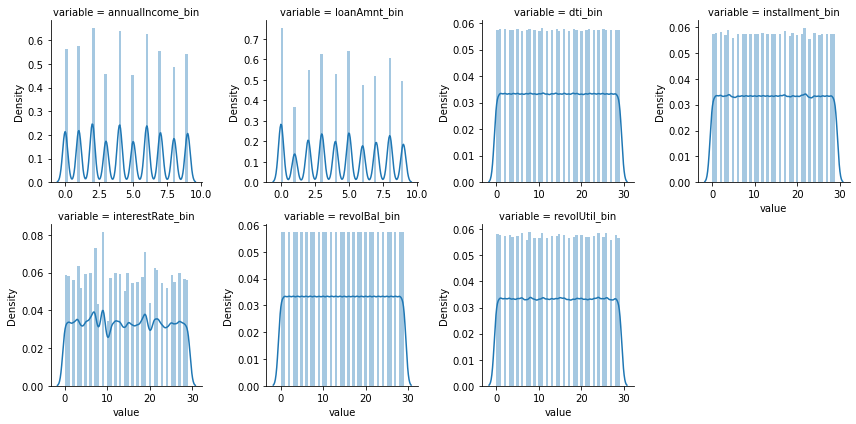

In [27]:
f = pd.melt(train, value_vars=[
    "annualIncome_bin", "loanAmnt_bin", "dti_bin", "installment_bin", 
    "interestRate_bin", "revolBal_bin", "revolUtil_bin"
])
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
g.figure.savefig("assets/distribution/num_dist_after_bin.png")

In [28]:
cate_features = [
    "term", "grade", "subGrade", "employmentLength", "purpose", 'homeOwnership',
    "verificationStatus", "initialListStatus", "applicationType",
    "regionCode", "postCode", "title", "employmentTitle",
    "issueDate", "earliesCreditLine",
    'annualIncome_bin', 'loanAmnt_bin', 'installment_bin', 'interestRate_bin', 'revolBal_bin', 'revolUtil_bin', 'dti_bin' 
]


In [86]:
train.to_csv("data/process_train.csv", index=False)

test.to_csv("data/process_test.csv", index=False)